# <div style="color:#fff;display:fill;border-radius:10px;background-color:#0066CC;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> - | Notebook resume </div>

<p style="font-size:18px; font-family:verdana; line-height: 1.7em; margin-left:20px">   
Throughout this notebook I'll try to achieve a decent score on the Wallmart Sales competition a least in the top 10% (medal zone). With the last update I'm in the top 3%.
</p>

# <div style="color:#fff;display:fill;border-radius:10px;background-color:#0066CC;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> - | Challenge description </div>

<p style="font-size:18px; font-family:verdana; line-height: 1.7em; margin-left:20px">
One challenge of modeling retail data is the need to make decisions based on limited history. If Christmas comes but once a year, so does the chance to see how strategic decisions impacted the bottom line.
In this recruiting competition, job-seekers are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains many departments, and participants must project the sales for each department in each store. To add to the challenge, selected holiday markdown events are included in the dataset. These markdowns are known to affect sales, but it is challenging to predict which departments are affected and the extent of the impact.
Want to work in a great environment with some of the world's largest data sets? This is a chance to display your modeling mettle to the Walmart hiring teams.
This competition counts towards rankings & achievements.  If you wish to be considered for an interview at Walmart, check the box "Allow host to contact me" when you make your first entry. 
You must compete as an individual in recruiting competitions. You may only use the provided data to make your predictions.
</p>

# <div style="color:#fff;display:fill;border-radius:10px;background-color:#0066CC;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> - | Table of contents</div>

* [1-Libraries](#section-one)
* [2-Data loading](#section-two)
* [3-EDA](#section-three)
    * [3.1-Sales analysis](#subsection-three-one)
    * [3.2-Other feature analysis](#subsection-three-two)
    * [3.3-Heatmap and correlation between features](#subsection-three-three)
* [4-Feature engineering](#section-four)
    - [4.1-Holidays](#subsection-four-one)
    - [4.2-Markdowns](#subsection-four-two)
* [5-Preprocessing](#section-five)
    - [5.1-Filling missing values](#subsection-five-one)
    - [5.2-Encoding categorical data](#subsection-five-two)
* [6-Feature Selection](#section-six)
* [7-Modeling](#section-seven)
    * [7.1-Baseline prediction](#subsection-seven-one)
    * [7.2-Simple blend](#subsection-seven-two)

<a id="section-one"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#0066CC;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 1 | Libraries</div>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode()

from sklearn import model_selection
from sklearn import metrics, ensemble, linear_model
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore') 

<a id="section-two"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#0066CC;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 2 | Data loading</div>

In [ ]:
features = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/features.csv.zip')
train = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/train.csv.zip')
stores = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/stores.csv')
test = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/test.csv.zip')
sample_submission = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip')

In [ ]:
feature_store = features.merge(stores, how='inner', on = "Store")

In [ ]:
train_df = train.merge(feature_store, how='inner', on = ['Store','Date','IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)

In [ ]:
test_df = test.merge(feature_store, how='inner', on = ['Store','Date','IsHoliday']).sort_values(by = ['Store','Dept','Date']).reset_index(drop=True)

<a id="section-three"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#0066CC;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 3 | Exploratory Data Analysis (EDA)</div>

<p style="font-size:18px; font-family:verdana; line-height: 1.7em; margin-left:20px">
The EDA is one of the most important parts of the process, because will gives you an idea about the relationship of the features, your distribution, and so on.
    <br><br>

In [ ]:
train_df.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

In [ ]:
feature_store = features.merge(stores, how='inner', on = "Store")

# Converting date column to datetime 
feature_store['Date'] = pd.to_datetime(feature_store['Date'])
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# Adding some basic datetime features
feature_store['Day'] = feature_store['Date'].dt.day
feature_store['Week'] = feature_store['Date'].dt.week
feature_store['Month'] = feature_store['Date'].dt.month
feature_store['Year'] = feature_store['Date'].dt.year

In [ ]:
train_df = train.merge(feature_store, how='inner', on = ['Store','Date','IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)

In [ ]:
test_df = test.merge(feature_store, how='inner', on = ['Store','Date','IsHoliday']).sort_values(by = ['Store','Dept','Date']).reset_index(drop=True)

In [ ]:
df_weeks = train_df.groupby('Week').sum()

<a id="subsection-three-one"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#0066CC80;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:10px"> 3.1 | Sales analysis</div>

In [ ]:
palette = px.colors.qualitative.Safe

In [ ]:
px.line( data_frame = df_weeks, x = df_weeks.index, y = 'Weekly_Sales', 
        labels = {'Weekly_Sales' : 'Weekly Sales', 'x' : 'Weeks' }, 
        title = 'Sales over weeks', color_discrete_sequence=palette)

<div class="alert alert-info" style="border-radius:10px; font-size:16px; font-family:verdana; line-height: 1.7em;margin-left:20px">
<strong>Insights:</strong>
The sales across the year are quite stable, with a plunge around the week 42, and a recovery for the holidays.
</div>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em; margin-left:20px">
<b> Markdowns relationship with sales </b></p>

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown1'], name = 'MarkDown1', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown2'], name = 'MarkDown2', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown3'], name = 'MarkDown3', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown4'], name = 'MarkDown4', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown5'], name = 'MarkDown5', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['Weekly_Sales'], name = 'Weekly Sales', mode = 'lines') )
fig.update_layout(title = "Sales vs Markdown's", xaxis_title = 'Weeks')

<p style="font-size:20px; font-family:verdana; line-height: 1.7em; margin-left:20px">
<b> Mean sales comparassion across the years
         </b></p>

In [ ]:
weekly_sales = train_df.groupby(['Year','Week'], as_index = False).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2010 = train_df.loc[train_df['Year']==2010].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2011 = train_df.loc[train_df['Year']==2011].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2012 = train_df.loc[train_df['Year']==2012].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter( x = weekly_sales2010['Weekly_Sales']['mean'].index, y = weekly_sales2010['Weekly_Sales']['mean'], name = 'Mean Sales 2010', mode = 'lines') )
fig.add_trace(go.Scatter( x = weekly_sales2011['Weekly_Sales']['mean'].index, y = weekly_sales2011['Weekly_Sales']['mean'], name = 'Mean Sales 2011', mode = 'lines') )
fig.add_trace(go.Scatter( x = weekly_sales2012['Weekly_Sales']['mean'].index, y = weekly_sales2012['Weekly_Sales']['mean'], name = 'Mean Sales 2012', mode = 'lines') )
fig.add_annotation(text="Thanksgiving", x=47, y=25000, showarrow=False)
fig.add_annotation(text="Christmas", x=51, y=29000, showarrow=False)
fig.update_layout(title = 'Sales 2010, 2011, 2012', xaxis_title = 'Weeks')

<div class="alert alert-info" style="border-radius:10px; font-size:16px; font-family:verdana; line-height: 1.7em;margin-left:20px">
<strong>Insights:</strong>
There's a clear pattern about the sales across the years, by Thanksgiving and Christmas the sales rise up by a huge margin.
</div>

<a id="subsection-three-two"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#0066CC80;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:10px"> 3.2 | Other features analysis</div>

In [ ]:
# Converting the temperature to celsius for a better interpretation
train_df['Temperature'] = train_df['Temperature'].apply(lambda x :  (x - 32) / 1.8)
train_df['Temperature'] = train_df['Temperature'].apply(lambda x :  (x - 32) / 1.8)

In [ ]:
train_plt = train_df.sample(frac=0.20)

In [ ]:
px.histogram(train_plt, x='Temperature', y ='Weekly_Sales', color='IsHoliday', marginal='box', opacity= 0.6,
           title = 'Temperature and sales by holiday', color_discrete_sequence=palette)

<div class="alert alert-info" style="border-radius:10px; font-size:15px; font-family:verdana; line-height: 1.7em;margin-left:20px">
<strong>Insights:</strong>
There is a pattern between the coldness and the sales, obviously related to the fact that the USA is in the northern hemisphere, and it is a country where a large part of it experiences cold temperatures for this time.
</div>

In [ ]:
px.histogram(train_plt, x='Fuel_Price', y ='Weekly_Sales', color='IsHoliday', marginal='box', opacity= 0.6,
           title='Fuel price and sales by holiday',color_discrete_sequence=palette)

<div class="alert alert-info" style="border-radius:10px; font-size:16px; font-family:verdana; line-height: 1.7em;margin-left:20px">
<strong>Insights:</strong>
There is not a very clear pattern here, but you can see that the lower the fuel price, the more sales.
</div>

In [ ]:
px.histogram(train_plt, x='CPI', y ='Weekly_Sales', color='IsHoliday', marginal='box', opacity= 0.6,
           title='CPI and sales by holiday',color_discrete_sequence=palette)

<div class="alert alert-info" style="border-radius:10px; font-size:16px; font-family:verdana; line-height: 1.7em;margin-left:20px">
<strong>Insights:</strong>
Here there is not a very clear pattern either, you can see that there are 3 groups, but in all of them you have sales, despite the fact that the CPI is higher.
</div>

In [ ]:
px.histogram(train_plt, x='Unemployment', y ='Weekly_Sales', color='IsHoliday', marginal='box', opacity= 0.6,
           title='Unemployment rate and sales by holiday',color_discrete_sequence=palette)

<div class="alert alert-info" style="border-radius:10px; font-size:16px; font-family:verdana; line-height: 1.7em;margin-left:20px">
<strong>Insights:</strong>
In relation to unemployment, it can be seen that the lower the value, higher the sales, it makes sense.
</div>

In [ ]:
sizes= train_plt.groupby('Size').mean()
px.line(sizes, x = sizes.index, y = sizes.Weekly_Sales, 
        title='Store size and sales',color_discrete_sequence=palette)

<div class="alert alert-info" style="border-radius:10px; font-size:16px; font-family:verdana; line-height: 1.7em;margin-left:20px">
<strong>Insights:</strong>
Size is an important factor when it comes to sales, as you can see here. 
</div>

In [ ]:
store_type = pd.concat([stores['Type'], stores['Size']], axis=1)
px.box(store_type, x='Type', y='Size', color='Type', 
       title='Store size and Store type',color_discrete_sequence=palette)

<p style="font-size:15px; font-family:verdana; line-height: 1.7em">
<div class="alert alert-info" style="border-radius:10px; font-size:16px; font-family:verdana; line-height: 1.7em;margin-left:20px">
<strong>Insights:</strong>
Within size we can see that there are 3 types of stores, the A are the most present.
</div>

In [ ]:
store_sale = pd.concat([stores['Type'], train_df['Weekly_Sales']], axis=1)
px.box(store_sale.dropna(), x='Type', y='Weekly_Sales', color='Type', 
       title='Store type and sales',color_discrete_sequence=palette)

<p style="font-size:15px; font-family:verdana; line-height: 1.7em">
<div class="alert alert-info" style="border-radius:10px; font-size:16px; font-family:verdana; line-height: 1.7em;margin-left:20px">
<strong>Insights:</strong>
In relation to the type of store we can see that although the C are the smallest ones, they are those that have the highest median sales.
</div>

In [ ]:
depts= train_plt.groupby('Dept').mean().sort_values(by='Weekly_Sales', ascending='False')
bar=px.bar(depts, x = depts.index, y =  depts.Weekly_Sales, 
           title='Departament and sales',color=depts.Weekly_Sales)
bar.update_layout(barmode='group', xaxis={'categoryorder':'total descending'})

<p style="font-size:15px; font-family:verdana; line-height: 1.7em">
    <br><br>
<div class="alert alert-info" style="border-radius:10px; font-size:16px; font-family:verdana; line-height: 1.7em;margin-left:20px">
  <strong>Insights:</strong>
 <div>Some departaments contributes to sales more than others.
</div>
</div>

<a id="subsection-three-three"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#0066CC80;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:10px"> 3.3 | Heatmap and correlation between features</div>

In [ ]:
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
df_mask = corr.mask(mask).round(2)

fig = ff.create_annotated_heatmap(z=df_mask.to_numpy(), 
                                  x=df_mask.columns.tolist(),
                                  y=df_mask.columns.tolist(),
                                  colorscale=px.colors.diverging.RdBu,
                                  hoverinfo="none", 
                                  showscale=True, ygap=1, xgap=1
                                 )

fig.update_xaxes(side="bottom")

fig.update_layout(
    title_text='Heatmap', 
    title_x=0.5, 
    width=900, 
    height=700,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    yaxis_autorange='reversed',
    template='plotly_white'
)

for i in range(len(fig.layout.annotations)):
    if fig.layout.annotations[i].text == 'nan':
        fig.layout.annotations[i].text = ""

fig.show()

In [ ]:
weekly_sales_corr = train_df.corr().iloc[2,:]
corr_df = pd.DataFrame(data = weekly_sales_corr, index = weekly_sales_corr.index ).sort_values (by = 'Weekly_Sales', ascending = False)
corr_df = corr_df.iloc[1:]
bar = px.bar(corr_df, x = corr_df.index, y = 'Weekly_Sales', color=corr_df.index, labels={'index':'Featues'},
             title='Feature correlation with sales',color_discrete_sequence=palette)
bar.update_traces(showlegend=False)

<a id="section-four"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#0066CC;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:0px"> 4 | Feature engineering </div>

In [ ]:
data_train = train_df.copy()
data_test = test_df.copy()

<a id="subsection-four-one"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#0066CC80;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:10px"> 4.1 | Holidays</div>

<p style="font-size:18px; font-family:verdana; line-height: 1.7em;margin-left:30px">
Since Thanksgiving and Christmas are the most importarnt holidays, I'm going to try some feature engineering on this features, and also Superbowl and Laborday.
    <br><br>

In [ ]:
data_train['Days_to_Thansksgiving'] = (pd.to_datetime(train_df["Year"].astype(str)+"-11-24", format="%Y-%m-%d") - pd.to_datetime(train_df["Date"], format="%Y-%m-%d")).dt.days.astype(int)
data_train['Days_to_Christmas'] = (pd.to_datetime(train_df["Year"].astype(str)+"-12-24", format="%Y-%m-%d") - pd.to_datetime(train_df["Date"], format="%Y-%m-%d")).dt.days.astype(int)

In [ ]:
data_test['Days_to_Thansksgiving'] = (pd.to_datetime(test_df["Year"].astype(str)+"-11-24", format="%Y-%m-%d") - pd.to_datetime(test_df["Date"], format="%Y-%m-%d")).dt.days.astype(int)
data_test['Days_to_Christmas'] = (pd.to_datetime(test_df["Year"].astype(str)+"-12-24", format="%Y-%m-%d") - pd.to_datetime(test_df["Date"], format="%Y-%m-%d")).dt.days.astype(int)

In [ ]:
data_train['SuperBowlWeek'] = train_df['Week'].apply(lambda x: 1 if x == 6 else 0)
data_train['LaborDay'] = train_df['Week'].apply(lambda x: 1 if x == 36 else 0)
data_train['Tranksgiving'] = train_df['Week'].apply(lambda x: 1 if x == 47 else 0)
data_train['Christmas'] = train_df['Week'].apply(lambda x: 1 if x == 52 else 0)

In [ ]:
data_test['SuperBowlWeek'] = test_df['Week'].apply(lambda x: 1 if x == 6 else 0)
data_test['LaborDay'] = test_df['Week'].apply(lambda x: 1 if x == 36 else 0)
data_test['Tranksgiving'] = test_df['Week'].apply(lambda x: 1 if x == 47 else 0)
data_test['Christmas'] = test_df['Week'].apply(lambda x: 1 if x == 52 else 0)

<a id="subsection-four-two"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#0066CC80;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:10px"> 4.2 | Markdowns</div>

In [ ]:
data_train['MarkdownsSum'] = train_df['MarkDown1'] + train_df['MarkDown2'] + train_df['MarkDown3'] + train_df['MarkDown4'] + train_df['MarkDown5'] 

In [ ]:
data_test['MarkdownsSum'] = test_df['MarkDown1'] + test_df['MarkDown2'] + test_df['MarkDown3'] + test_df['MarkDown4'] + test_df['MarkDown5']

<a id="section-five"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#0066CC;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:0px"> 5 | Preprocessing</div>

<a id="subsection-five-one"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#0066CC80;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:10px"> 5.1 | Filling missing values</div>

In [ ]:
data_train.isna().sum()[data_train.isna().sum() > 0].sort_values(ascending=False)

In [ ]:
data_test.isna().sum()[data_test.isna().sum() > 0].sort_values(ascending=False)

In [ ]:
data_train.fillna(0, inplace = True)

In [ ]:
data_test['CPI'].fillna(data_test['CPI'].mean(), inplace = True)
data_test['Unemployment'].fillna(data_test['Unemployment'].mean(), inplace = True)

In [ ]:
data_test.fillna(0, inplace = True)

<a id="subsection-five-two"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#0066CC80;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:10px"> 5.2 | Encoding categorical data</div>

In [ ]:
data_train['IsHoliday'] = data_train['IsHoliday'].apply(lambda x: 1 if x == True else 0)
data_test['IsHoliday'] = data_test['IsHoliday'].apply(lambda x: 1 if x == True else 0)

In [ ]:
data_train['Type'] = data_train['Type'].apply(lambda x: 1 if x == 'A' else (2 if x == 'B' else 3))
data_test['Type'] = data_test['Type'].apply(lambda x: 1 if x == 'A' else (2 if x == 'B' else 3))

<a id="section-six"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#0066CC;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:0px"> 6 | Feature selection</div>

In [ ]:
features = [feature for feature in data_train.columns if feature not in ('Date','Weekly_Sales')]

In [ ]:
X = data_train[features].copy()
y = data_train.Weekly_Sales.copy()

In [ ]:
data_sample = data_train.copy().sample(frac=.25)
X_sample = data_sample[features].copy()
y_sample = data_sample.Weekly_Sales.copy()

In [ ]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_sample, y_sample, random_state=0, test_size=0.15)

In [ ]:
feat_model = xgb.XGBRegressor(random_state=0).fit(X_train, y_train)

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(feat_model, random_state=1).fit(X_valid, y_valid)
features = eli5.show_weights(perm, top=len(X_train.columns), feature_names = X_valid.columns.tolist())

In [ ]:
features_weights = eli5.show_weights(perm, top=len(X_train.columns), feature_names = X_valid.columns.tolist())
features_weights

In [ ]:
f_importances = pd.Series(dict(zip(X_valid.columns.tolist(), perm.feature_importances_))).sort_values(ascending=False)
f_importances

In [ ]:
weights = eli5.show_weights(perm, top=len(X_train.columns), feature_names=X_valid.columns.tolist())
result = pd.read_html(weights.data)[0]
result

<div class="alert alert-info" style="border-radius:10px; font-size:16px; font-family:verdana; line-height: 1.7em;margin-left:20px">
Seems to be Dept, Store, Size, CPI, Week, are the top 5 features.
</div>

<a id="section-seven"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#0066CC;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:0px"> 7 | Modeling</div>

In [ ]:
# Eval metric for the competition
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

In [ ]:
models = {
          '    LGBM': lgb.LGBMRegressor(random_state = 0),
          ' XGBoost': xgb.XGBRegressor(random_state = 0, objective = 'reg:squarederror'),
          'Catboost': cb.CatBoostRegressor(random_state = 0, verbose=False),          
          '    HGBR': HistGradientBoostingRegressor(random_state = 0),
          ' ExtraTr': ensemble.ExtraTreesRegressor(bootstrap = True, random_state = 0),
          ' RandomF': ensemble.RandomForestRegressor(random_state = 0),
         }

In [ ]:
def model_evaluation (name, model, models, X_train, y_train, X_valid, y_valid):
   
    rmses = []
    
    for i in range(len(models)):
    
        # Model fit
        model.fit(X_train, y_train)
        
        # Model predict
        y_preds = model.predict(X_valid)

        # RMSE
        rmse = np.sqrt(np.mean((y_valid - y_preds)**2))
        rmses.append(rmse)
        
    return np.mean(rmses)

In [ ]:
for name, model in models.items():
    print(name + ' Valid RMSE {:.4f}'.format(model_evaluation(name, model, models,  X_train, y_train, X_valid, y_valid)) )

<div class="alert alert-info" style="border-radius:10px; font-size:16px; font-family:verdana; line-height: 1.7em;margin-left:20px">
Seems to be RandomForest it's the best baseline model by default, followed by ExtraTrees, but you can improve the score of boosting models by doing hyperparameter optimization. Also, for a more generalizable model you can do a blend of the best models at the end.
</div>

<a id="subsection-seven-one"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#0066CC80;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:10px"> 7.1 | Baseline predictions</div>

<p style="font-size:18px; font-family:verdana; line-height: 1.7em; margin-left:30px">
Stablish a baseline with the best model. </p>
<br>

In [ ]:
X_baseline = X[['Store','Dept','IsHoliday','Size','Week','Type','Year','Day']].copy()

In [ ]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_baseline, y, random_state=0, test_size=0.1)

In [ ]:
RF = ensemble.RandomForestRegressor(n_estimators=60, max_depth=25, min_samples_split=3, min_samples_leaf=1)
RF.fit(X_train, y_train)

In [ ]:
test = data_test[['Store','Dept','IsHoliday','Size','Week','Type','Year','Day']].copy()
predict_rf = RF.predict(test)

In [ ]:
sample_submission['Weekly_Sales'] = predict_rf
sample_submission.to_csv('submission.csv',index=False)

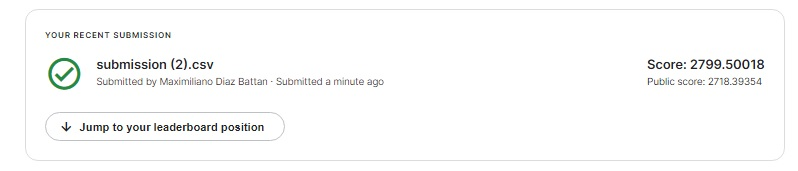

<a id="subsection-seven-two"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#0066CC80;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:10px"> 7.2 | Simple Blend </div>

<p style="font-size:16px; font-family:verdana; line-height: 1.7em; margin-left:30px">
Blend baseline with the two best model Random Forest and Extra Trees.
</p><br>

In [ ]:
ETR = ensemble.ExtraTreesRegressor(n_estimators=50, bootstrap = True, random_state = 0)
ETR.fit(X_train, y_train)

In [ ]:
predict_etr = ETR.predict(test)

In [ ]:
avg_preds = (predict_rf + predict_etr) / 2

In [ ]:
sample_submission['Weekly_Sales'] = avg_preds
sample_submission.to_csv('submission.csv',index=False)

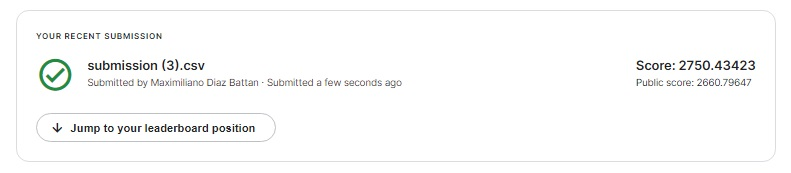

<p style="font-size:20px; font-family:verdana; line-height: 1.7em; margin-left:30px">
Thanks for taking the time to read my notebook </p>